In [344]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
# from nltk.probability import FreqDist
from pathlib import Path
import glob
import random
import pandas as pd
import re
# import requests
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold, cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB,ComplementNB,CategoricalNB
from statistics import mean, stdev
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

In [280]:
def process_file(file_name, file_list):
    txt_re = re.compile(file_name)
    fname = list(filter(txt_re.search, file_list))[0]
    
    # check file size to make sure the txt file actually has text
    file_size = 0
    while file_size == 0:
        file_size = Path(fname).stat().st_size
        if file_size != 0: # check if conversion to txt didn't work
            with open(fname, 'r') as f:
                text = f.read()
        else:
            print('Empty file, returning None')
            return None
    text_lower = text.lower()
    tokens = word_tokenize(text_lower)
    stop_words = set(stopwords.words('english'))

    filtered_tokens = [t for t in tokens if t not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    
    return lemmatized_words

In [281]:
txt_files = glob.glob('/Users/antonhesse/Desktop/Anton/Education/UMN/Lab and Research/HSPL/CPET_scoping_review/data/cpet_articles/txts/*.txt')
gas_clf_df = pd.read_csv('/Users/antonhesse/Desktop/Anton/Education/UMN/Lab and Research/HSPL/CPET_scoping_review/data/cpet_articles/Manual text analysis - Gas clf.csv')
gas_clf_df['txt_file_name'] = gas_clf_df.apply(lambda x: str(x['Article'] + '.txt'), axis=1)
# gas_clf_df = gas_clf_df[(gas_clf_df['Eligible'] == 'e') & (gas_clf_df['External ref'] == 'n')].reset_index(drop=True)

In [282]:
for idx, row in gas_clf_df.iterrows():
    if row['Eligible'] != 'e':
        row['Gas data'] = 'n'
    if row['External ref'] == 'y':
        row['Gas data'] = 'n'

In [283]:
analyzed_txt_files = gas_clf_df['txt_file_name'].to_list()

In [284]:
word_lists = [process_file(f, txt_files) for f in tqdm(analyzed_txt_files)]
joined_word_lists = [' '.join(text) for text in word_lists]

  0%|          | 0/594 [00:00<?, ?it/s]

In [285]:
gas_clf_df[gas_clf_df['Gas data'].isnull()]

,Article,Eligible,Eligibility note,External ref,Gas data,txt_file_name


In [286]:
gas_data = gas_clf_df['Gas data'].to_list()
counts = gas_clf_df['Gas data'].value_counts()
print(f'Values counts:\n{counts}')
props = round(gas_clf_df['Gas data'].value_counts() / sum(gas_clf_df['Gas data'].value_counts()) * 100,1)
print()
print(f'Proportions:\n{props}')

Values counts:
n    308
y    286
Name: Gas data, dtype: int64

Proportions:
n    51.9
y    48.1
Name: Gas data, dtype: float64


You can use CountVectorizier and TfidfTransformer together, or just use TfidfVectorizer because that combines those steps together. With a Pipeline, however, I'm unsure if you need to separate those two steps or not.

In [299]:
names = [
#     'MultinomialNB',
#     'BernoulliNB',
#     'GaussianNB',
#     'ComplementNB',
#     'Logistic',
    'RandomForest',
#     'DecisionTree',
#     'KNeighborsClassifier'
#     'SGDClassifier',
#     'SVC',
#     'LinearSVC',
#     'NuSVC'
]

classifiers = [
#     MultinomialNB(),
#     BernoulliNB(),
#     GaussianNB(),
#     ComplementNB(),
#     LogisticRegression(),
    RandomForestClassifier(),
#     DecisionTreeClassifier(),
#     KNeighborsClassifier(n_neighbors=18),
#     SGDClassifier(),
#     SVC(kernel='linear', degree=3, gamma='auto', probability=True,),
#     LinearSVC(),
#     NuSVC(probability=True)
]

scores_df = pd.DataFrame(columns = names)
scores_df.insert(0, 'Metric', ['Mean', 'Median', 'Min', 'Max', 'SD', 'Comp_time'])

In [288]:
# compare accuracy of different models
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(joined_word_lists)
rskf_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2)

In [297]:
for name, clf in tqdm(zip(names, classifiers), total=len(classifiers)):
    start = time.time()
    clf.fit(X.toarray(), gas_data)
    scores = cross_val_score(clf, X.toarray(), gas_data, cv = rskf_cv)
    end = time.time()
    minutes = round((end - start) // 60,0)
    seconds = round((end - start) % 60,0)
    comp_time = '{minutes}:{seconds}'.format(minutes = minutes, seconds = seconds)
    scores_df[name] = [
        round(np.mean(scores)*100,1),
        round(np.median(scores)*100,1),
        round(min(scores)*100,1),
        round(max(scores)*100,1),
        round(stdev(scores*100),1),
        comp_time
    ]

  0%|          | 0/5 [00:00<?, ?it/s]

In [298]:
scores_df

,Metric,MultinomialNB,BernoulliNB,GaussianNB,ComplementNB,RandomForest
0,Mean,68.8,68.6,66.5,67.9,79.9
1,Median,68.1,68.5,67.2,68.5,80.3
2,Min,63.9,61.3,62.2,63.0,75.6
3,Max,74.8,72.9,69.7,72.3,83.1
4,SD,4.0,3.3,2.8,2.6,2.6
5,Comp_time,0.0:8.0,0.0:12.0,0.0:17.0,0.0:5.0,0.0:47.0


In [300]:
folder = Path('/Users/antonhesse/Desktop/Anton/Education/UMN/Lab and Research/HSPL/CPET_scoping_review/data/cpet_articles/pdfs/manual_pdf_analysis/')
manual_analysis_txts = [re.sub('.pdf', '.txt', path.name) for path in folder.rglob('*.pdf')]

In [301]:
def list_intersection(lst1, lst2, output = 'intersection'):
    if output == 'intersection':
        return list(set(lst1).intersection(lst2))
    elif output == 'difference':
        return list(set(lst1).difference(lst2))
    elif output == 'symmetric_difference':
        return list(set(lst1).symmetric_difference(lst2))
    else:
        print('Bad input, returning None')
        return None


In [302]:
test_articles = list_intersection(manual_analysis_txts, analyzed_txt_files, output='difference')
word_lists_test = [process_file(f, txt_files) for f in tqdm(test_articles)]
joined_word_lists_test = [' '.join(text) for text in word_lists_test]

  0%|          | 0/407 [00:00<?, ?it/s]

In [303]:
estimators = [(name, clf) for name, clf in zip(names, classifiers)]
estimators
vote_soft = VotingClassifier(estimators=estimators, voting='soft')
vote_soft.fit(X, gas_data)

VotingClassifier(estimators=[('RandomForest', RandomForestClassifier())],
                 voting='soft')

In [304]:
scores = cross_val_score(vote_soft, X, gas_data, cv = rskf_cv)

In [305]:
print(round(np.mean(scores)*100,1))
print(round(np.median(scores)*100,1))

80.1
79.8


In [306]:
X_test = vectorizer.transform(joined_word_lists_test)
preds = vote_soft.predict_proba(X_test)

In [307]:
test_dict = {
    'article': test_articles,
    'pred_n': preds[:,0],
    'pred_y': preds[:,1],
    'pred_0.5': abs(preds[:,0]-0.5)
}
test_df = pd.DataFrame.from_dict(test_dict)
test_df['pred'] = test_df.apply(lambda x: 'y' if x['pred_n'] < 0.5 else 'n', axis=1)
test_df['article'] = test_df['article'].apply(lambda x: x.replace('.txt', ''))

In [311]:
# test_df[(test_df['pred'] == 'y') & (test_df['pred_0.5'] < 0.20)].sort_values(by = 'pred_0.5', ascending=True)
# test_df[(test_df['pred'] == 'n') & (test_df['pred_n'] > 0.6)].sort_values(by = 'pred_n', ascending=False).iloc[0:20,:]

test_df[test_df['pred_0.5'] < 0.08].sort_values(by = 'pred_0.5', ascending=True).loc[:,['article', 'pred_0.5']]


,article,pred_0.5
7,j.msard.2022.103721,0.000000
175,bmj.4.5787.577,0.000000
61,hrt.54.6.562,0.000000
130,01.cir.0000049746.29175.3f,0.010000
83,jc.84.7.2303,0.010000
401,fphys.2018.01048,0.010000
284,mss.0000000000001204,0.020000
206,j.1523-1755.2003.00739.x,0.020000
129,jsep.2013-0251,0.020000
397,hrt.61.5.421,0.022500


In [327]:
rfc = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [500, 750, 1000],
}

In [328]:
X_train, X_test, y_train, y_test = train_test_split(joined_word_lists, gas_data, test_size=0.3, random_state=42)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)

In [329]:
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': [500, 750, 1000]})

In [330]:
CV_rfc.best_params_

{'n_estimators': 500}

In [331]:
rfc_best = RandomForestClassifier(n_estimators=500, random_state=42)
rfc_best.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [332]:
pred = rfc_best.predict(X_test)

In [333]:
acc = accuracy_score(y_test, pred)
print("Accuracy for Random Forest on CV data: ", round(acc*100,1))

Accuracy for Random Forest on CV data:  84.4


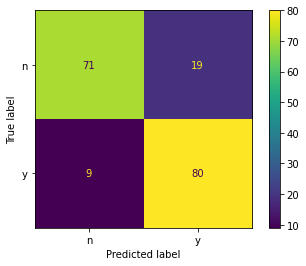

In [346]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()